In [2]:
%matplotlib inline
import pandas

In [3]:
# Tools for downloading dataset
def trips_basename(year, month):
    import calendar
    firstday, lastday = (1, calendar.monthrange(year, month)[1])
    return "trips-{year}.{month}.{firstday}-{year}.{month}.{lastday}".format(**locals())
def trips_url(year, month):
    base = trips_basename(year, month)
    extension = '.csv.zip'
    server_dir = 'http://oslo-citybike.s3.amazonaws.com/exports/'
    return server_dir + base + extension

def download_trip(year, month):
    import urllib.request
    from io import BytesIO
    from zipfile import ZipFile
    import os.path
    
    url = trips_url(year, month)
    filename = trips_basename(year, month) + '.csv'
    outpath = "data/"+filename
    if os.path.exists(outpath):
        print('skipping existing %s' % (url))
        return outpath
    
    print('downloading %s' % (url,))
    
    # Download ZIP to memory
    # ZipFile requires seek() which urlib does not implement
    temp = BytesIO()
    temp.write(urllib.request.urlopen(url).read())
    zipfile = ZipFile(temp)

    # Write to disk
    csvfile = open(outpath, 'wb+')
    csvfile.write(zipfile.read(filename))

    csvfile.close()
    zipfile.close()
    return outpath

def months_between(start, end):
    periods = []
    current = list(start)
    while (current != list(end)):
        periods.append(tuple(current))

        # calculate next
        if current[1] == 12:
            # end of year
            current[0] += 1
            current[1] = 1
        else:
           # just new month
           current[1] += 1
    return periods

start = (2016, 6)
end = (2017, 8)
notexisting = [
    (2017, 1), (2017, 2), (2017, 3)
]
periods = sorted(set(months_between(start, end)).difference(notexisting))
for period in periods:
    try:
        filename = download_trip(*period)
    except Exception as e:
        raise RuntimeError("Could not download %d-%d: %s" % (*period, e.msg))
"done"

skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.6.1-2016.6.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.7.1-2016.7.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.8.1-2016.8.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.9.1-2016.9.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.10.1-2016.10.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.11.1-2016.11.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.12.1-2016.12.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.4.1-2017.4.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.5.1-2017.5.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.6.1-2017.6.30.csv.zip
skipping existing http:/

'done'

In [4]:
import json
stations = json.loads(open('data/oslo_stations.json', 'r').read())
stations['stations'][:3]

[{'bounds': [{'latitude': 59.915418602160436, 'longitude': 10.762068629264832},
   {'latitude': 59.91565254992276, 'longitude': 10.762672126293182},
   {'latitude': 59.915807169665264, 'longitude': 10.762433409690855},
   {'latitude': 59.91557994562126, 'longitude': 10.761821866035461},
   {'latitude': 59.915418602160436, 'longitude': 10.762068629264832}],
  'center': {'latitude': 59.91562, 'longitude': 10.762248},
  'id': 157,
  'in_service': True,
  'number_of_locks': 30,
  'subtitle': 'mellom Norbygata og Urtegata',
  'title': 'Nylandsveien'},
 {'bounds': [{'latitude': 59.938998693156904, 'longitude': 10.758989453315735},
   {'latitude': 59.939057810485, 'longitude': 10.759515166282652},
   {'latitude': 59.93939638951557, 'longitude': 10.759338140487671},
   {'latitude': 59.93932383715719, 'longitude': 10.758823156356812},
   {'latitude': 59.938998693156904, 'longitude': 10.758989453315735}],
  'center': {'latitude': 59.939192, 'longitude': 10.759168},
  'id': 158,
  'in_service': T

In [5]:
# NOTE: Uses about 700MB of RAM
from datetime import datetime

def parse_date(val):
    # ref http://strftime.org/
    date_format = "%Y-%m-%d %H:%M:%S %z"
    return datetime.strptime(first, date_format)

trips = pandas.DataFrame()
for period in periods[:1]:
    filename = "data/"+ trips_basename(*period)+'.csv'
    print('reading', filename)
    frame = pandas.read_csv(filename, index_col=None, header=0, parse_dates=[1, 3])
    trips = pandas.concat([trips, frame])
trips[:3]

reading data/trips-2016.6.1-2016.6.30.csv


,Start station,Start time,End station,End time
0,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14
1,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46
2,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14


In [6]:
number_trips = trips.shape[0]
number_trips

292302

In [7]:
trips.set_index(['Start time'], drop=False, inplace=True)
first = trips['Start time'].min()
last = trips['Start time'].max()
first, last

(Timestamp('2016-06-01 03:59:59'), Timestamp('2016-06-30 21:59:53'))

In [8]:
period = trips['2016-06-03':'2016-06-03']
period[:3]

,Start station,Start time,End station,End time
Start time,,,,
2016-06-03 04:00:05,206,2016-06-03 04:00:05,212,2016-06-03 04:20:46
2016-06-03 04:00:05,267,2016-06-03 04:00:05,252,2016-06-03 06:44:13
2016-06-03 04:00:06,222,2016-06-03 04:00:06,247,2016-06-03 04:06:47


In [9]:
# How are stations connected to eachother?
period = trips['2016-06-03':'2016-07-13']
cross = pandas.crosstab(period['Start station'], period['End station'])
relative = cross.div(cross.sum(axis=1), axis=0)
relative[:3]

End station,157,159,160,161,162,163,164,167,170,172,...,287,288,290,291,292,293,294,298,301,302
Start station,,,,,,,,,,,,,,,,,,,,,
157,0.123377,0.000000,0.005348,0.000000,0.004584,0.029794,0.019481,0.003056,0.000000,0.002292,...,0.010313,0.014515,0.000382,0.000000,0.001910,0.001528,0.028648,0.000000,0.007257,0.012987
159,0.003911,0.099739,0.003911,0.004563,0.019557,0.015645,0.011082,0.001956,0.000000,0.006519,...,0.003911,0.005215,0.000652,0.003259,0.003259,0.003911,0.020209,0.001956,0.002608,0.009126
160,0.004156,0.002267,0.090669,0.003022,0.006045,0.011334,0.011711,0.007934,0.000756,0.001889,...,0.012089,0.006045,0.006045,0.000756,0.017756,0.007934,0.022667,0.003022,0.007178,0.019267


Return to same station    0.07093
dtype: float64

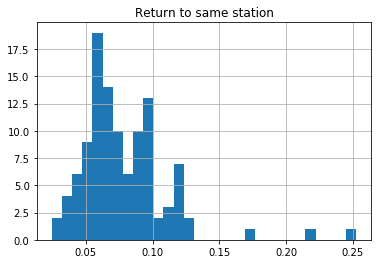

In [10]:
### Do people return to same station often?
import numpy
self_ = pandas.DataFrame(numpy.diag(relative), columns=('Return to same station',))
self_.hist(bins=30)
# About 5-10% of the trips go back to same stations
self_.median()

In [103]:
# Are there cycles in the movement of bikes?
period = trips['2016-06-03':'2016-06-03']
cross = pandas.crosstab(period['Start station'], period['End station'])
relative = cross.div(cross.sum(axis=1), axis=0)
D, P = np.linalg.eig(relative.values@relative.values)
P

array([[-0.09712859+0.j        ,  0.04633341+0.j        ,
         0.04054120+0.j        , ...,  0.27245712+0.03143182j,
         0.27245712-0.03143182j, -0.05915254+0.j        ],
       [-0.09712859+0.j        ,  0.07817837+0.j        ,
        -0.20514748+0.j        , ...,  0.03464479-0.0491572j ,
         0.03464479+0.0491572j ,  0.03441338+0.j        ],
       [-0.09712859+0.j        ,  0.04341273+0.j        ,
         0.04784373+0.j        , ..., -0.03944733-0.00489869j,
        -0.03944733+0.00489869j,  0.03169879+0.j        ],
       ..., 
       [-0.09712859+0.j        , -0.18662104+0.j        ,
        -0.17687769+0.j        , ..., -0.03485668-0.00329273j,
        -0.03485668+0.00329273j,  0.03984177+0.j        ],
       [-0.09712859+0.j        , -0.05158592+0.j        ,
         0.03210547+0.j        , ...,  0.01830765-0.02019034j,
         0.01830765+0.02019034j,  0.01474035+0.j        ],
       [-0.09712859+0.j        , -0.05621116+0.j        ,
         0.06445354+0.j      

In [11]:
# Enrich dataset with trip durations
trips['Duration'] = trips['End time'] - trips['Start time']


trips['Duration'].describe()

count                    292302
mean     0 days 00:28:30.015425
std      0 days 03:30:13.330161
min             0 days 00:00:07
25%             0 days 00:05:55
50%             0 days 00:09:39
75%             0 days 00:17:57
max            22 days 16:38:20
Name: Duration, dtype: object

In [12]:
# Are own trips just errors?
own_trips = trips[trips['Start station'].eq(trips['End station'])]
percentiles = [0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 0.90, 0.95]
comp = pandas.DataFrame([trips['Duration'].describe(percentiles=percentiles), own_trips['Duration'].describe(percentiles=percentiles)])
# 30% of return-to-same trips are below 1 minute. Where as < 3% of all trips are below. Probably errors!
# But, also the 75 percentile is 50 minutes for return-to-same versus.
# So people do spend longer time when going back to same place. Possibly not returning the bike it and returning?
# Would be come clearer if we would remove the 'errors'
comp

,count,mean,std,min,3%,5%,10%,20%,30%,40%,50%,75%,90%,95%,max
Duration,292302,00:28:30.015425,03:30:13.330161,00:00:07,00:01:15,00:02:21,00:03:37,00:05:13,00:06:35,00:08:00,00:09:39,00:17:57,00:59:31,01:54:10,22 days 16:38:20
Duration,22948,00:40:45.077348,03:28:28.028896,00:00:07,00:00:16,00:00:18,00:00:22,00:00:32,00:00:49,00:01:29,00:06:24,00:51:11.250000,02:01:44,02:39:11.299999,19 days 02:47:19


In [20]:
# Enrich trip data with distance of the trip
import geopy.distance
import math
stations_by_id = {} # id -> data
for station in stations['stations']:
    station_id = station['id']
    # sanity checking
    if not isinstance(station_id, int):
        raise ValueError("Station identifier not an integer: %s" % repr(station_id))
    if stations_by_id.get(station_id):
        raise ValueError("Duplicate station id: %d" % (station_id,))
    stations_by_id[station_id] = station
def station_location(station_id):
    station = stations_by_id.get(station_id, None)
    if not station:
        return None
    point = station['center']
    return (point['latitude'], point['longitude'])
def calculate_distance(row):
    start = station_location(int(row['Start station']))
    end = station_location(int(row['End station']))
    if start is None or end is None:
        return math.nan
    dist = geopy.distance.great_circle(start, end)
    return dist.meters

subs = trips # [:5].copy()
subs['Distance'] = subs.apply(calculate_distance, 'columns')
subs[:5]

,Start station,Start time,End station,End time,Duration,Distance
Start time,,,,,,
2016-06-01 03:59:59,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14,00:02:15,610.115142
2016-06-01 04:00:02,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46,00:18:44,2917.746920
2016-06-01 04:00:06,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14,00:02:08,354.690116
2016-06-01 04:00:06,206,2016-06-01 04:00:06,233,2016-06-01 04:02:47,00:02:41,767.072410
2016-06-01 04:00:06,184,2016-06-01 04:00:06,179,2016-06-01 04:15:13,00:15:07,2986.506648


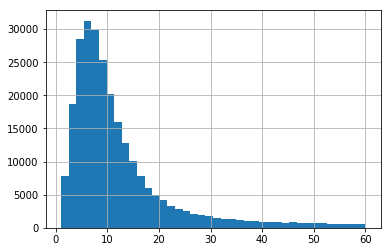

In [62]:
# Convert from nanoseconds, remove timedelta type
trips['Duration Seconds'] = pandas.Series(trips['Duration'], dtype='int64').abs() / (1000*1000*1000)
(trips['Duration Seconds'] / 60).hist(bins=40, range=(1, 60))

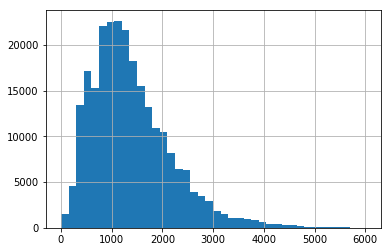

In [35]:
# 0 is a very common distance (travel back to self), ignore it
trips['Distance'].hist(bins=40, range=(1, 6000))

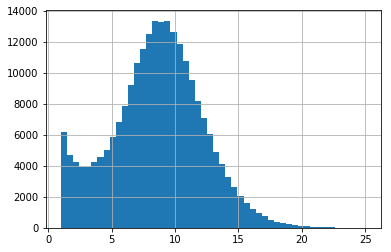

In [80]:
(trips['Velocity'] * 3.6).hist(bins=50, range=(1,25))

In [81]:
trips['Velocity'].median() * 3.6

7.930948670850242

In [75]:
# FIXME: use vector division on whole dataframe? Cant be done with timeperiod type though?
def calculate_velocity(row):
    velocity = row['Distance'] / row['Duration'].total_seconds()
    return velocity
 
#subs['Velocity'] = subs.apply(calculate_velocity, 'columns')
trips['Velocity'] = trips['Distance'] / trips['Duration Seconds'] 
trips[:3]

,Start station,Start time,End station,End time,Duration,Distance,Duration Seconds,Velocity
Start time,,,,,,,,
2016-06-01 03:59:59,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14,00:02:15,610.115142,135.0,4.519371
2016-06-01 04:00:02,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46,00:18:44,2917.746920,1124.0,2.595860
2016-06-01 04:00:06,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14,00:02:08,354.690116,128.0,2.771017


In [15]:
# Find missing station info
def not_nan(n):
    return not math.isnan(n)
known_stations = set(stations_by_id.keys())
start_stations = set(filter(not_nan, trips['Start station'].unique()))
end_stations =  set(filter(not_nan, trips['End station'].unique()))
trip_stations = start_stations | end_stations
unknown_stations = trip_stations - known_stations
unknown_stations

{172, 173, 186, 271, 288}

In [16]:
# Trips with missing start/end stations
missing_start = trips[pandas.isnull(trips['Start station'])]
missing_end = trips[pandas.isnull(trips['End station'])]
len(missing_start + missing_end)

0

In [17]:
len(trips['End station'].unique())

110

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


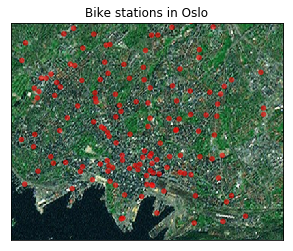

In [161]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

def create_map():

    # http://spatialreference.org/ref/epsg/27393/
    epsg=27393 # Oslo III
    epsg=3857 # Implies some Mercator projection, need to set upper/lower corners and lat_ts

    m = Basemap(resolution='l', epsg=epsg,
                llcrnrlon=10.70, urcrnrlon=10.80, llcrnrlat=59.90, urcrnrlat=59.94,
                lat_ts=59.93)

    m.arcgisimage()
    return m

station_map = create_map()
# TODO: calculate mapbounds from station info / trips present in dataset
for station in stations['stations']:
    center = station['center']
    lon, lat = center['longitude'], center['latitude'] 
    poly = station_map.tissot(lon,lat,0.0005,64,facecolor='red',zorder=10,alpha=0.6)

ax = plt.gca()
plt.title("Bike stations in Oslo")
plt.show()

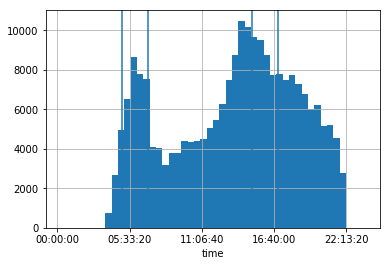

In [190]:
timeofday = trips.copy()
timeofday['timeofday'] = trips.index.time
series = timeofday['timeofday']
axs = series[trips.index.weekday < 5].hist(bins=48)
axs.axvline(x=5*3600)
axs.axvline(x=7*3600)
axs.axvline(x=15*3600)
axs.axvline(x=17*3600)

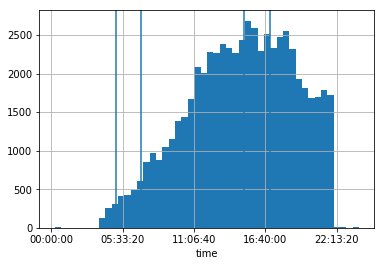

In [191]:
series = timeofday['timeofday']
axs = series[trips.index.weekday >= 5].hist(bins=48)
axs.axvline(x=5*3600)
axs.axvline(x=7*3600)
axs.axvline(x=15*3600)
axs.axvline(x=17*3600)

In [206]:
# How are stations connected? Clustering
from sklearn.cluster import SpectralClustering

def cluster_connected(frame, n_clusters=9):
    # Create affinity matrix
    outbound = pandas.crosstab(frame['Start station'], frame['End station'])
    inbound = pandas.crosstab(frame['End station'], frame['Start station'])

    connectivity = inbound + outbound
    np.fill_diagonal(connectivity.values, 0)
    connectivity[:4]

    # Perform clustering
    cluster = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    labels = cluster.fit_predict(connectivity)
    labels

    # Map back to station IDs
    station_clusters = [ [] for n in range(0, n_clusters) ]
    for idx, label in enumerate(labels):
        station = connectivity.columns[idx]
        #print(idx, station, label)
        station_clusters[label].append(station)

    station_clusters = sorted(station_clusters, key=len, reverse=True)
    return station_clusters

def plot_station_groups(station_groups):
    colors = ['red', 'blue', 'orange', 'magenta', 'yellow', 'aqua', 'darkblue', 'orangered', 'pink', 'black', 'grey' ]
    assert len(colors) >= len(station_groups), "Missing colors %d" % (len(colors)-len(station_clusters),)

    connecivity_map = create_map()
        
    for idx, cluster in enumerate(station_groups):
        for station_id in cluster:
            station = stations_by_id.get(station_id, None)
            if not station:
                continue
            center = station['center']
            lon, lat = center['longitude'], center['latitude']
            color = colors[idx]
            poly = station_map.tissot(lon,lat,0.0004,64,facecolor=color,zorder=10,alpha=1.0)

    ax = plt.gca()
    return ax


[44, 20, 18, 14, 7, 7]


/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


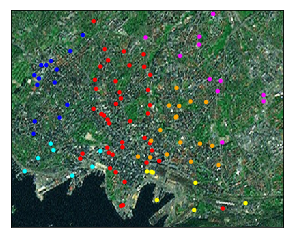

In [226]:
df = trips['2016-06-03':'2016-07-03']
df = df[df.index.weekday >= 5]
clustered = cluster_connected(df, n_clusters=6)
print([len(c) for c in clustered])
plot_station_groups(clustered)

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


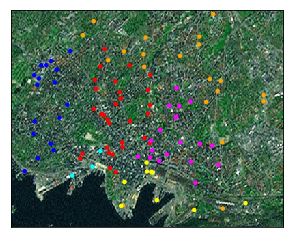

In [229]:
df = trips[trips.index.weekday < 5 ]
#df = df.between_time('10:00', '12:00')
clustered = cluster_connected(df, n_clusters=6)
plot_station_groups(clustered)

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


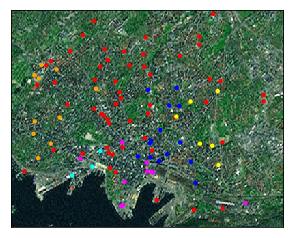

In [231]:
df = trips[trips.index.weekday < 5 ]
df = df.between_time('5:00', '8:00')
clustered = cluster_connected(df, n_clusters=6)
plot_station_groups(clustered)

In [ ]:
# TODO: calculate connenectivity within clusters, and between them

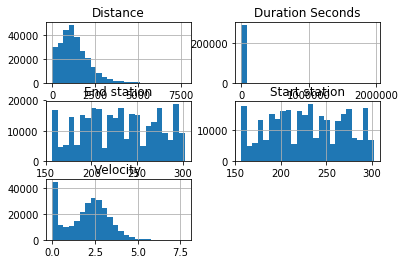

In [110]:
# What travel patterns are there during the day?
# How to find out?